# Customer Satisfaction Airline Survey, Analysis and Prediction

This notebook is to showcase: 
- Basics of data science (data cleaning, encoding, feature engineering, and model training)
- Predicting Customer Satisfaction based on the customer satisfaction survey, with customer feedback on their experience with the airline
Data Source:
others:Kaggle
https://seaborn.pydata.org/index.html#


### 1. Import data files, pandas, matplotlib, seaborn, numpy, spicy & Skelearn

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from eli5.sklearn import PermutationImportance

print('Modules are imported.')

Modules are imported.


In [2]:
# Import csv files
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
# File to Load, Source: Kaggle
test = "Resources/test.csv"
train ="Resources/train.csv"

In [3]:
# read csv file
testdf = pd.read_csv(test)
testdf.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied


In [4]:
# read csv file
traindf = pd.read_csv(train)
traindf.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


### 2. Clean and transform dataset Survey Results

In [5]:
#testpd.shape
traindf.shape

(103904, 25)

In [6]:
# Drop unnecessary columns
traindf = traindf.drop('Unnamed: 0', axis=1)
traindf = traindf.drop('id', axis=1)

In [7]:
#traindf.info()

In [8]:
# Drop unnecessary columns
testdf = testdf.drop('Unnamed: 0', axis=1)
testdf = testdf.drop('id', axis=1)

In [9]:
#testdf.info()

In [10]:
# Replace spaces in the column names with underscore
traindf.columns = [c.replace(' ', '_') for c in traindf.columns]
testdf.columns = [c.replace(' ', '_') for c in testdf.columns]

In [11]:
traindf['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
testdf['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

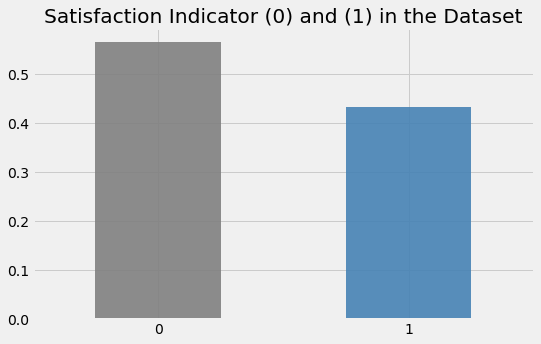

In [12]:
# Confirm satisfaction values changes
fig = plt.figure(figsize = (8,5))
traindf.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['gray','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset')
plt.show()


The plot shows a distribution of around 55%:45% between neutral/dissatisfied passengers and satisfied passengers respectively. So the data is quite balanced and it does not require any special treatment/resampling.

In [13]:
# Missing data
total = traindf.isnull().sum().sort_values(ascending=False)
percent = (traindf.isnull().sum()/traindf.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Arrival_Delay_in_Minutes,310,0.002984
satisfaction,0,0.000000
Food_and_drink,0,0.000000
Customer_Type,0,0.000000
Age,0,0.000000


In [14]:
# Imputing missing value with mean
traindf['Arrival_Delay_in_Minutes'] = traindf['Arrival_Delay_in_Minutes'].fillna(traindf['Arrival_Delay_in_Minutes'].mean())
testdf['Arrival_Delay_in_Minutes'] = testdf['Arrival_Delay_in_Minutes'].fillna(testdf['Arrival_Delay_in_Minutes'].mean())

In [15]:
# Check the list of categorical variables in dataset
traindf.select_dtypes(include=['object']).columns

Index(['Gender', 'Customer_Type', 'Type_of_Travel', 'Class'], dtype='object')

In [16]:
# Replace NaN with mode for categorical variables
traindf['Gender'] = traindf['Gender'].fillna(traindf['Gender'].mode()[0])
traindf['Customer_Type'] = traindf['Customer_Type'].fillna(traindf['Customer_Type'].mode()[0])
traindf['Type_of_Travel'] = traindf['Type_of_Travel'].fillna(traindf['Type_of_Travel'].mode()[0])
traindf['Class'] = traindf['Class'].fillna(traindf['Class'].mode()[0])

In [17]:
testdf['Gender'] = testdf['Gender'].fillna(testdf['Gender'].mode()[0])
testdf['Customer_Type'] = testdf['Customer_Type'].fillna(testdf['Customer_Type'].mode()[0])
testdf['Type_of_Travel'] = testdf['Type_of_Travel'].fillna(testdf['Type_of_Travel'].mode()[0])
testdf['Class'] = testdf['Class'].fillna(testdf['Class'].mode()[0])

### 3.Survey Results of survey customer satisfaction responses

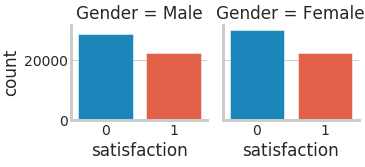

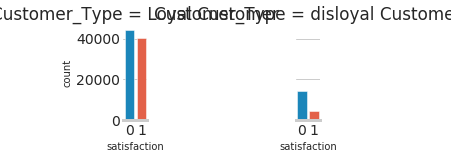

In [18]:
# seaborn graph satifaction info

with sns.axes_style(style='whitegrid'):
    g = sns.catplot("satisfaction", col="Gender", col_wrap=2, data=traindf, kind="count", height=2.5, aspect=1.0)  
    g = sns.catplot("satisfaction", col="Customer_Type", col_wrap=2, data=traindf, kind="count", height=2.5, aspect=1.0)
    g.set_xlabels(fontsize=10)
    g.set_ylabels(fontsize=10)
    
    g.despine(left=True)
  

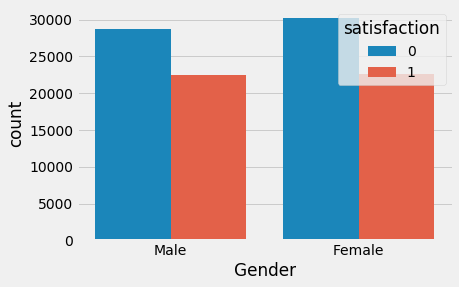

In [19]:
ax = sns.countplot(x="Gender", hue="satisfaction", data=traindf)

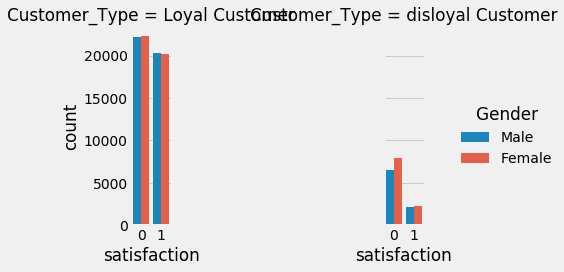

In [20]:
g = sns.catplot(x="satisfaction", hue="Gender", col="Customer_Type", data=traindf, kind="count",
                height=4, aspect=.7)

###### Gender Analysis Survey Results
The analysis hows gender-wise distribution of dissatisfied and satisfied customers are quite the same. 
For both male and female passengers, the number of dissatisfied customers is not higher than the satisfied customers.
###### Customer Type Analysis Survey Results
The number of loyal customers is higher than the non-loyal. 
Among loyal passengers, the ratio of satisfied and dissatidfied ones is 49:51.

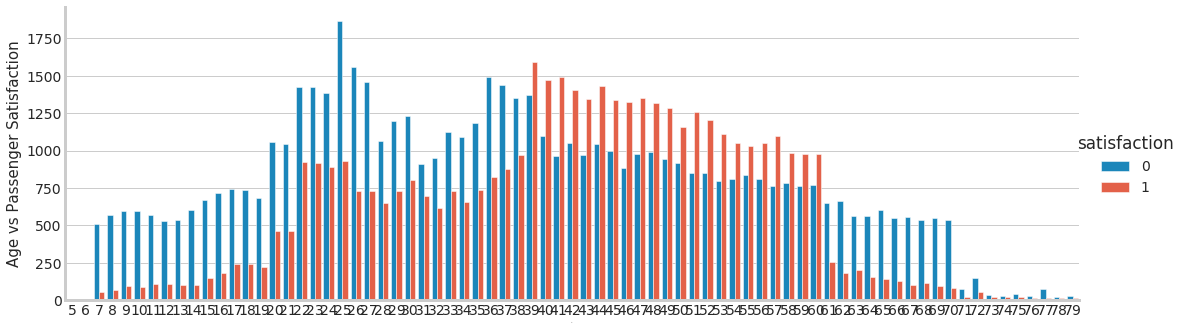

In [21]:
with sns.axes_style('whitegrid'):
    g = sns.catplot("Age", data=traindf, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80))
    g.set_ylabels('Age vs Passenger Satisfaction', fontsize=15)
    g.set_xlabels(fontsize=0.5)

###### Age Analysis Survey Results
From age 7-38 and from age 61-79 ranges, quotient of dissatisfied passengers is higher compared to satisfied passengers. 
In age 39-60 range, quotient of satisfied passengers is higher compared to dissatisfied passengers.

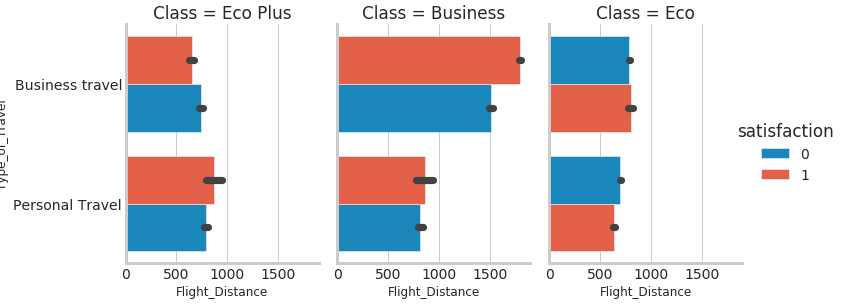

In [22]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Flight_Distance", y="Type_of_Travel", hue="satisfaction", col="Class", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=12)
    g.set_ylabels(fontsize=12)

###### Type of Travel, Class, Flight Distance Survey Results: 
For business travel in business class category, the number of satisfied passengers are higher than longer flight distance. 
For other combinations, there is almost equal distribution of satisfied and dissatisfied passengers.

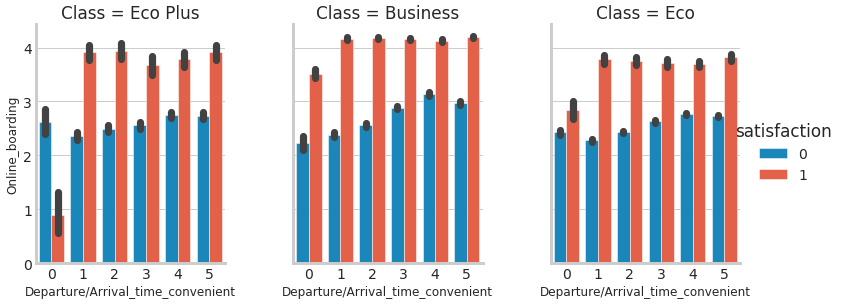

In [23]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Departure/Arrival_time_convenient", y="Online_boarding", hue="satisfaction", col="Class", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=12)
    g.set_ylabels(fontsize=12)

######  Survey Results, online Boarding, departure/Arrival time Convenience grouped by Class: 
- For Eco Plus class, Departure/Arrival time has negative responses with high number of dissatisfied passengers, even when online boarding has high satisfaction. 
- For other combinations, there is higher level of satisfaction.

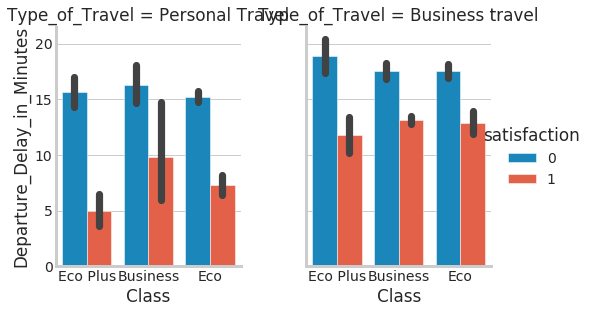

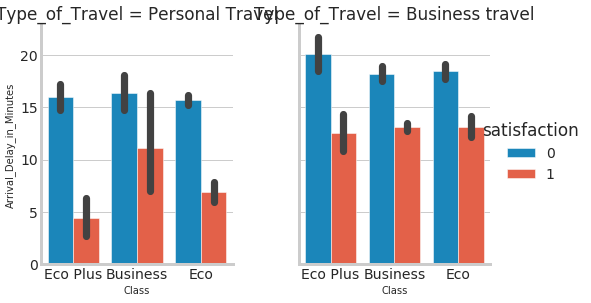

In [24]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Class", y="Departure_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=traindf, kind="bar", height=4.5, aspect=.8)
    g = sns.catplot(x="Class", y="Arrival_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=10)
    g.set_ylabels(fontsize=10)

###### Survey Results, departure delay, arrival delay grouped by type of travel: 
- For personal travel (specially Eco Plus and Eco), there is higher number of dissatisfied passengers when arrival delay in minutes is high. 
- By minute comparison, all combinations have higher no. of dissatisfied passengers compared to no. of satisfied passengers.

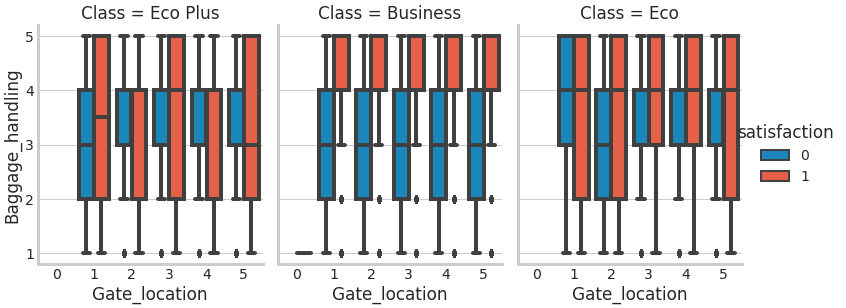

In [25]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Gate_location", y="Baggage_handling", hue="satisfaction", col="Class", data=traindf, kind="box", height=4.5, aspect=.8)

##### Survey Results, baggage handling, gate location grouped by class: 
- For business class, it is observed that all gate locations have higher number of dissatisfied passengers when baggage handling is not done perfectly well (rating <= 4). 
- For Eco Plus, when the gate location is 1 and for Eco, when the gate location is 2, even when the baggages are handled in a mediocre way (rating in range 2.0 - 4.0), passengers remained dissatisfied.

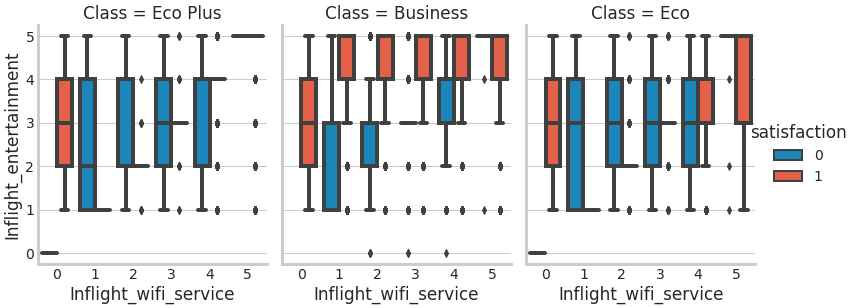

In [26]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Inflight_wifi_service", y="Inflight_entertainment", hue="satisfaction", col="Class", data=traindf, kind="box", height=4.5, aspect=.8)

##### Survey Results, inflight entertainment, inflight wi-fi service grouped by Class: 
- Economy Plus passengers are mostly satisfied without in-flight wi-fi service (rating 0) and medium level of in-flight entertainment (rating 2 - 4). 
- For Business class passengers, only highest level of in-flight entertainment (rating 5) can make them satisfied. 
- For Economy passengers, high level of in-flight entertainment (rating 3 - 5) and very high wi-fi service availability (rating 5) can make them satisfied.

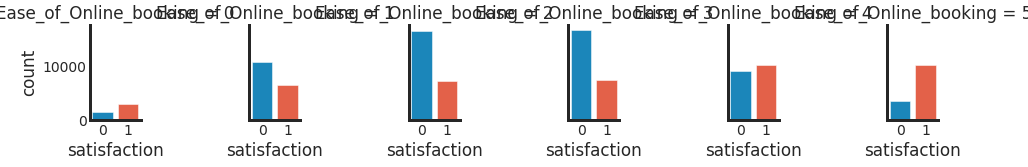

In [27]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Ease_of_Online_booking", col_wrap=6, data=traindf, kind="count", height=2.5, aspect=.9)

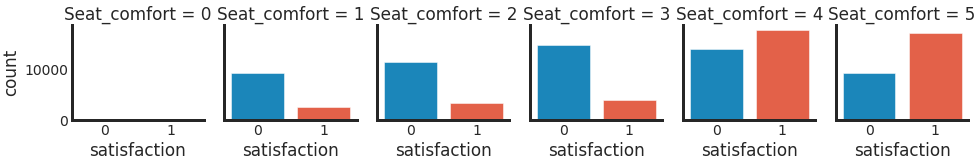

In [28]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Seat_comfort", col_wrap=6, data=traindf, kind="count", height=2.5, aspect=.9)

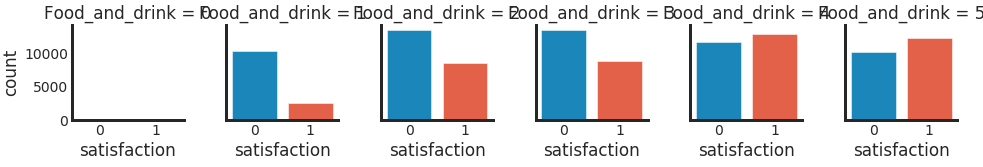

In [29]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Food_and_drink", col_wrap=6, data=traindf, kind="count", height=2.5, aspect=.9)

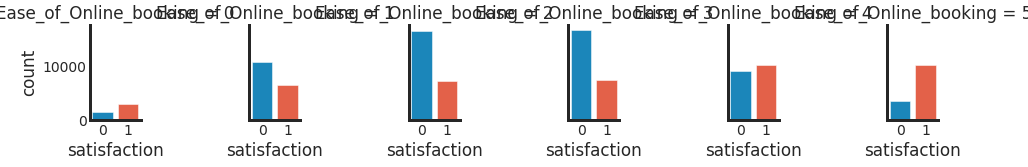

In [30]:

with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Ease_of_Online_booking", col_wrap=6, data=traindf, kind="count", height=2.5, aspect=.9)

##### Survey Results,  ease of online booking, seat comfort, cleanliness, food and drink: 
For above features, maximum nunber of satisfied passengers belong  to the category of 4 and 5 rating givers. 
Below rating 4, passengers are mostly dissatisfied.

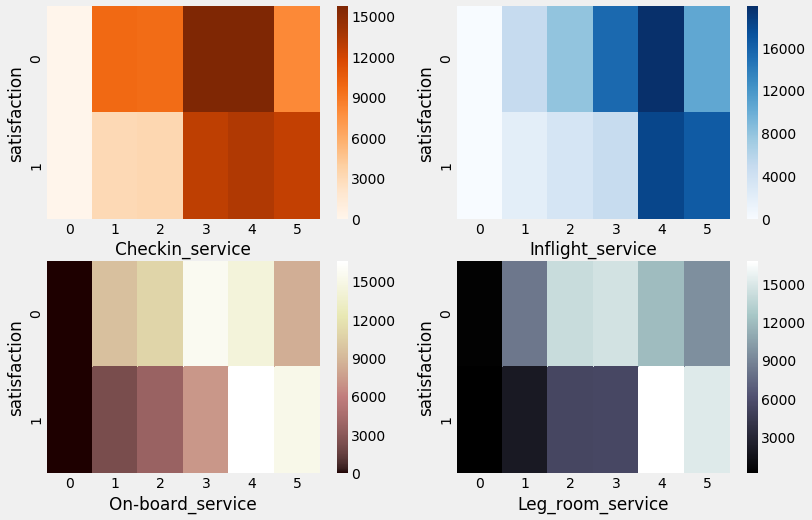

In [31]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))

table1 = pd.crosstab(traindf['satisfaction'], traindf['Checkin_service'])
sns.heatmap(table1, cmap='Oranges', ax = axarr[0][0])
table2 = pd.crosstab(traindf['satisfaction'], traindf['Inflight_service'])
sns.heatmap(table2, cmap='Blues', ax = axarr[0][1])
table3 = pd.crosstab(traindf['satisfaction'], traindf['On-board_service'])
sns.heatmap(table3, cmap='pink', ax = axarr[1][0])
table4 = pd.crosstab(traindf['satisfaction'], traindf['Leg_room_service'])
sns.heatmap(table4, cmap='bone', ax = axarr[1][1])

##### Survey results checkin service, inflight service, on-board service, leg-room service: 
- For checkin service, 0-2 rating givers are predominantly dissatisfied. 
- For other three services, only 4 and 5 rating givers belong to satisfied passengers category.

### 4 Label encoding of categorical variables

In [32]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in traindf.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    traindf[col] = lencoders[col].fit_transform(traindf[col])
#print (traindf.select_dtypes)

In [33]:
lencoders_t = {}
for col in testdf.select_dtypes(include=['object']).columns:
    lencoders_t[col] = LabelEncoder()
    testdf[col] = lencoders_t[col].fit_transform(testdf[col])

###### Outliers Detection and Removal

In [34]:
Q1 = traindf.quantile(0.25)
Q3 = traindf.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Gender                                  1.0
Customer_Type                           0.0
Age                                    24.0
Type_of_Travel                          1.0
Class                                   1.0
Flight_Distance                      1329.0
Inflight_wifi_service                   2.0
Departure/Arrival_time_convenient       2.0
Ease_of_Online_booking                  2.0
Gate_location                           2.0
Food_and_drink                          2.0
Online_boarding                         2.0
Seat_comfort                            3.0
Inflight_entertainment                  2.0
On-board_service                        2.0
Leg_room_service                        2.0
Baggage_handling                        2.0
Checkin_service                         1.0
Inflight_service                        2.0
Cleanliness                             2.0
Departure_Delay_in_Minutes             12.0
Arrival_Delay_in_Minutes               13.0
satisfaction                    

In [35]:
# Removing outliers from dataset
traindf = traindf[~((traindf < (Q1 - 1.5 * IQR)) |(traindf > (Q3 + 1.5 * IQR))).any(axis=1)]
traindf.shape

(61197, 23)

###### Correlation among Features

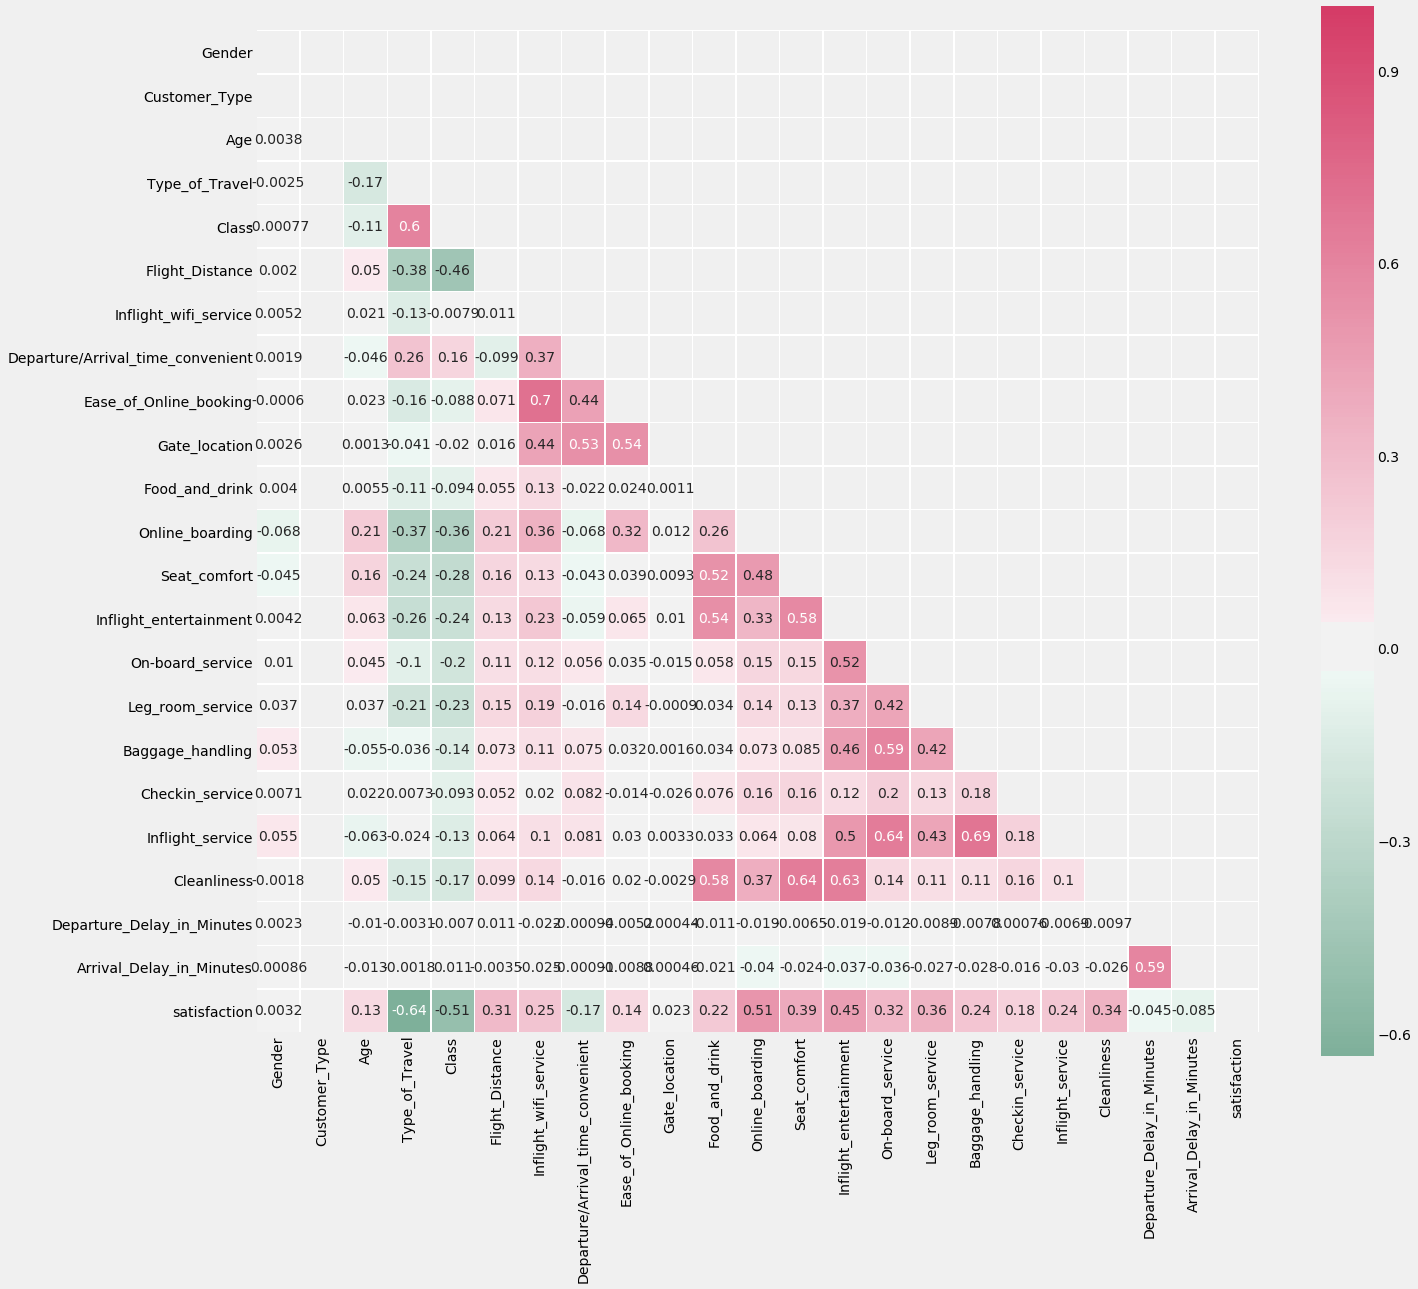

In [36]:
corr = traindf.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

"Ease_of_Online_booking" is highly correlated with "Inflight_wifi_service".
"Inflight_service" is highly correlated with "Baggage_handling". But no pair is having corr. coefficient exactly equal to 1. 
So there is no perfect multicollinearity. Hence we are not discarding any variable.

### 5. Top 10 Features Selection through Chi-Square

In [85]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(traindf)

modified_data = pd.DataFrame(r_scaler.transform(traindf), columns=traindf.columns)
modified_data.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1.0,0.0,0.076923,1.0,1.0,0.115789,0.6,0.8,0.6,0.2,...,1.0,0.8,0.6,0.75,0.666667,1.0,1.0,0.833333,0.56250,0.0
1,0.0,0.0,0.243590,0.0,0.0,0.299865,0.4,0.4,0.4,0.4,...,1.0,0.8,0.6,0.75,0.666667,0.8,1.0,0.000000,0.00000,1.0
2,1.0,0.0,0.692308,0.0,0.0,0.049393,0.6,0.6,0.6,0.6,...,0.6,0.6,0.8,0.75,0.333333,0.6,0.6,0.000000,0.00000,1.0
3,0.0,0.0,0.243590,1.0,0.5,0.310121,0.6,0.8,0.4,0.2,...,0.2,0.6,0.8,0.75,0.666667,0.8,0.2,0.000000,0.00000,0.0
4,1.0,0.0,0.512821,1.0,0.5,0.336032,0.4,0.8,0.4,0.6,...,0.4,0.6,0.6,0.75,0.333333,1.0,0.4,0.300000,0.71875,0.0


In [38]:
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='satisfaction']
y = modified_data[['satisfaction']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])


Index(['Type_of_Travel', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Online_boarding', 'Seat_comfort', 'Inflight_entertainment',
       'On-board_service', 'Leg_room_service', 'Cleanliness'],
      dtype='object')


In [77]:

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz
#import pydotplus
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier
#MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect 
#to the model parameters are computed to update the parameters.
#It can also have a regularization term added to the loss function that shrinks model parameters to prevent overfitting.
#This implementation works with data represented as dense numpy arrays or sparse scipy arrays of floating point values.

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

print('Modules are imported.')

Modules are imported.


#### 6. Feature Importance using Wrapper Method

In [62]:
X = traindf.drop('satisfaction', axis=1)
y = traindf['satisfaction']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

#Six features are inherently important in contributing towards passenger satisfaction. 
#To cross-check with another feature importance deciding method.

['Type_of_Travel', 'Class', 'Inflight_wifi_service', 'Online_boarding', 'Seat_comfort', 'Inflight_entertainment']
[0.00412513 0.         0.0258749  0.21982853 0.08990315 0.03140161
 0.12224491 0.01737014 0.03081474 0.01485982 0.01068989 0.11324523
 0.06338185 0.06652081 0.02798984 0.04231821 0.02388634 0.02276466
 0.02411625 0.03309566 0.00702376 0.00854455]


###### 7. Feature Permutation Importance
https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html
https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/


In [45]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.2723 ± 0.0039,Type_of_Travel
0.1278 ± 0.0026,Inflight_wifi_service
0.0435 ± 0.0011,Online_boarding
0.0424 ± 0.0013,Seat_comfort
0.0355 ± 0.0009,Checkin_service
0.0294 ± 0.0014,Inflight_service
0.0289 ± 0.0008,Baggage_handling
0.0246 ± 0.0006,Cleanliness
0.0177 ± 0.0007,On-board_service
0.0172 ± 0.0007,Class


From all above results, finally we can combine and conclude the list of important features.
Really Important Features: Type_of_Travel, Inflight_wifi_service, Online_boarding, Seat_comfort
Important Features: Class, Flight_Distance, Inflight_entertainment, On-board_service, Leg_room_service, Cleanliness, Checkin_service, Inflight_service, Baggage_handling

### 8. Building Models

In [46]:
features = ['Type_of_Travel','Inflight_wifi_service','Online_boarding','Seat_comfort','Flight_Distance',
            'Inflight_entertainment','On-board_service','Leg_room_service','Cleanliness','Checkin_service', 
            'Inflight_service', 'Baggage_handling']
target = ['satisfaction']

# Split into test and train
X_train = traindf[features]
y_train = traindf[target].to_numpy()
X_test = testdf[features]
y_test = testdf[target].to_numpy()

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [78]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
 
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train.ravel(), verbose=0)
    else:
        model.fit(X_train,y_train.ravel())
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model, X_test, y_test)                     
    
    return model, accuracy, roc_auc, time_taken

###### Model-1: Logistic Regression penalized with Elastic Net (L1 penalty = 50%, L2 penalty = 50%)

Accuracy = 0.8132891900215584
ROC Area under Curve = 0.8201667535234151
Time taken = 0.28931260108947754
              precision    recall  f1-score   support

           0    0.88771   0.76381   0.82111     14573
           1    0.74384   0.87652   0.80475     11403

    accuracy                        0.81329     25976
   macro avg    0.81578   0.82017   0.81293     25976
weighted avg    0.82455   0.81329   0.81393     25976



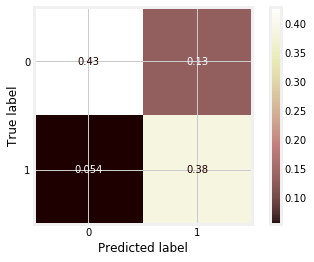

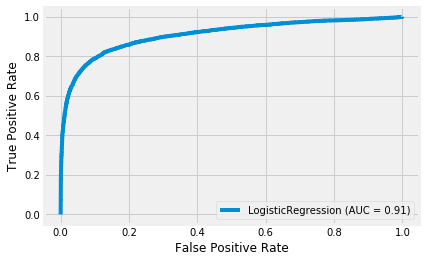

In [79]:
#from sklearn.linear_model import LogisticRegression imported already
params_lr = {'penalty': 'elasticnet', 'l1_ratio':0.5, 'solver': 'saga'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

In [47]:
#Regression Results
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.309527
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61197
Model:                          Logit   Df Residuals:                    61185
Method:                           MLE   Df Model:                           11
Date:                Sun, 27 Sep 2020   Pseudo R-squ.:                  0.5533
Time:                        22:05:13   Log-Likelihood:                -18942.
converged:                       True   LL-Null:                       -42406.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6437      0.016   -101.562      0.000      -1.675      -1.612
x2             0.2389      0.

###### 11 out of the 12 features in the survey results (except:Inflight_entertainment), have p-value < 0.05.
A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random).

These features have hight impact towards the target variable. A pseudo R-square value (McFadden's Pseudo R-Squared Value) of 0.55 represents an excellent fit.


### Model-2: Naive Bayes Classifier

Accuracy = 0.8334616569140745
ROC Area under Curve = 0.8345493488740687
Time taken = 0.046393632888793945
              precision    recall  f1-score   support

           0    0.87081   0.82564   0.84762     14573
           1    0.79102   0.84346   0.81640     11403

    accuracy                        0.83346     25976
   macro avg    0.83092   0.83455   0.83201     25976
weighted avg    0.83578   0.83346   0.83392     25976



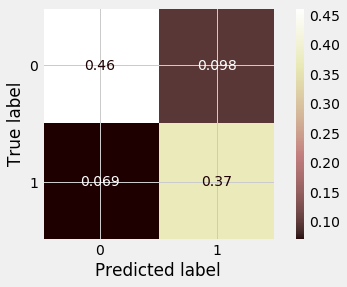

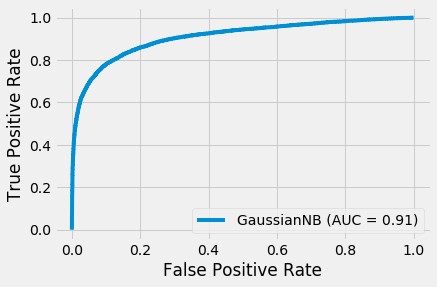

In [48]:
from sklearn.naive_bayes import GaussianNB

params_nb = {}

model_nb = GaussianNB(**params_nb)
model_nb, accuracy_nb, roc_auc_nb, tt_nb = run_model(model_nb, X_train, y_train, X_test, y_test)

### Model-3: K-Nearest Neighbor Classifier

Accuracy = 0.8861256544502618
ROC Area under Curve = 0.8870270908506304
Time taken = 6.2916765213012695
              precision    recall  f1-score   support

           0    0.91414   0.87964   0.89656     14573
           1    0.85326   0.89441   0.87335     11403

    accuracy                        0.88613     25976
   macro avg    0.88370   0.88703   0.88496     25976
weighted avg    0.88741   0.88613   0.88637     25976



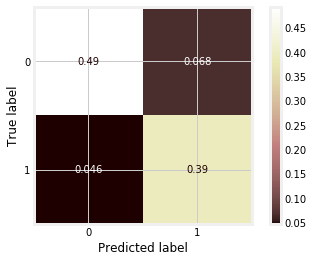

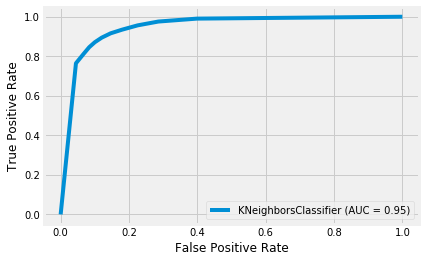

In [80]:
#from sklearn.neighbors import KNeighborsClassifier already called
params_kn = {'n_neighbors':10, 'algorithm': 'kd_tree', 'n_jobs':4}

model_kn = KNeighborsClassifier(**params_kn)
model_kn, accuracy_kn, roc_auc_kn, tt_kn = run_model(model_kn, X_train, y_train, X_test, y_test)

### Model-4: Decision Tree Classifier

Accuracy = 0.8671465968586387
ROC Area under Curve = 0.8732693543882251
Time taken = 0.05540013313293457
              precision    recall  f1-score   support

           0    0.93216   0.82310   0.87424     14573
           1    0.80333   0.92344   0.85921     11403

    accuracy                        0.86715     25976
   macro avg    0.86774   0.87327   0.86672     25976
weighted avg    0.87560   0.86715   0.86764     25976



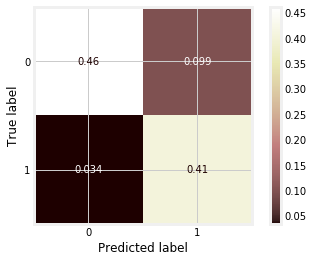

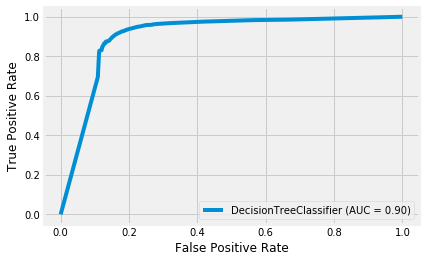

In [81]:
#from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Decision Tree is a white-box (explainable) model, deep-dive into the visualization for more valuable insights below. 
From tree-visualization, top extract rules which are contributing towards passenger-satisfaction.

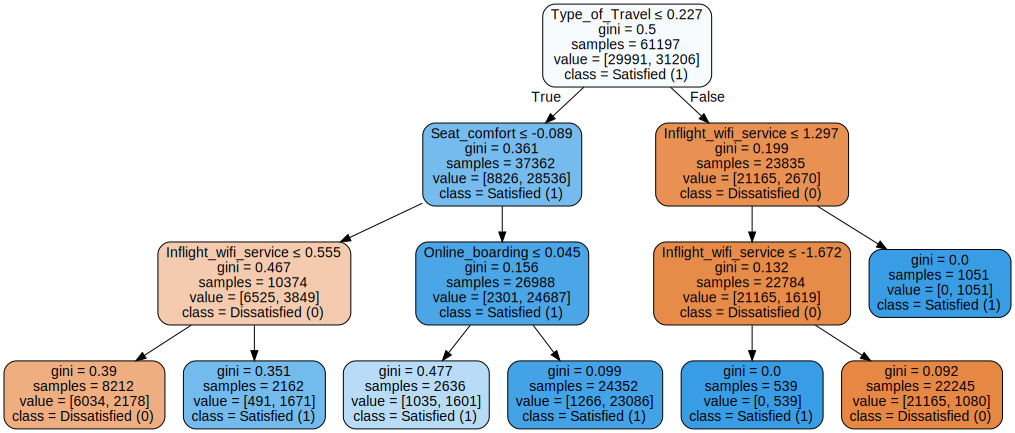

In [82]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

features_n = ['Type_of_Travel', 'Inflight_wifi_service', 'Online_boarding', 'Seat_comfort']
X_train_n = scaler.fit_transform(traindf[features_n])
data = export_graphviz(DecisionTreeClassifier(max_depth=3).fit(X_train_n, y_train), out_file=None, 
                       feature_names = features_n,
                       class_names = ['Dissatisfied (0)', 'Satisfied (1)'], 
                       filled = True, rounded = True, special_characters = True)
# Intentionally kept max_depth short visual-tree, best result comes with max_depth = 12
# Taken only really important features here to accommodate the entire tree picture
graph = graphviz.Source(data)
graph

### From Tree visualization:
"Type_of_Travel <=0.227 and Seat_comfort <= -0.089 and Online_boarding <= 0.045" (all normalized values) contributes towards passenger satisfaction indicator= 1. 
Following the same methodology, other rules can be extracted easily by going through the nodes.


### Model-5: Neural Network (Multilayer Perceptron)
https://scikit-learn.org/stable/modules/neural_networks_supervised.html
Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function f(.): R^m -> R^0 by training on a dataset, where  is the number of dimensions for input and  is the number of dimensions for output. 
Given a set of features X= x1,x2...xm) and a target , it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers.

Accuracy = 0.8678010471204188
ROC Area under Curve = 0.8760463843139631
Time taken = 25.789456844329834
              precision    recall  f1-score   support

           0    0.94825   0.80848   0.87281     14573
           1    0.79404   0.94361   0.86239     11403

    accuracy                        0.86780     25976
   macro avg    0.87114   0.87605   0.86760     25976
weighted avg    0.88055   0.86780   0.86823     25976



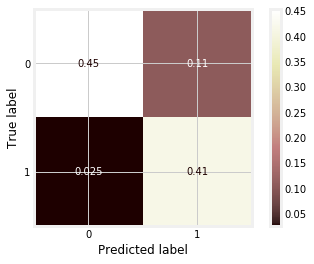

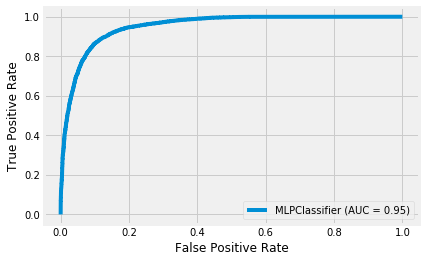

In [83]:
#from sklearn.neural_network import MLPClassifier
params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 100}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

### Model-6: Random Forest

Accuracy = 0.8941330458885125
ROC Area under Curve = 0.9003728693084586
Time taken = 4.760303497314453
              precision    recall  f1-score   support

           0    0.95723   0.84924   0.90001     14573
           1    0.83161   0.95150   0.88753     11403

    accuracy                        0.89413     25976
   macro avg    0.89442   0.90037   0.89377     25976
weighted avg    0.90208   0.89413   0.89453     25976



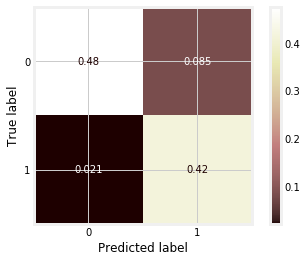

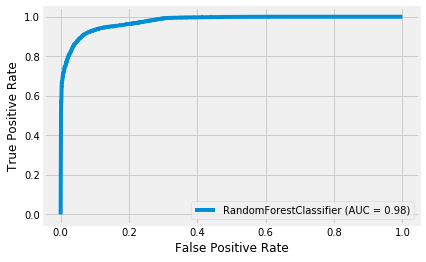

In [84]:
#from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

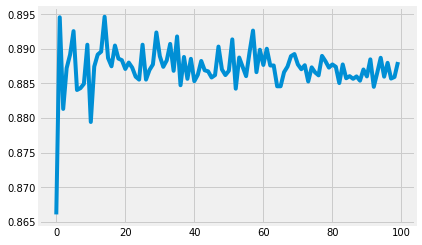

In [65]:
import numpy as np
%matplotlib inline

trees=range(100)
accuracy=np.zeros(100)

for i in range(len(trees)):
    clf = RandomForestClassifier(n_estimators = i+1)
    model1 = clf.fit(X_train, y_train.ravel())
    y_predictions = model1.predict(X_test)
    accuracy[i] = accuracy_score(y_test, y_predictions)

plt.plot(trees,accuracy)

From above graph, it is evident that minimum 40 trees are required to make accuracy fairly consistent (though minimal fluctuation is still there, and we can try the graph after increasing the no. of iterations).


### Model-7: Extreme Gradient Boosting
- XGBoost is an algorithm that has applied machine learning for structured or tabular data. 
- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance
This algorithm evaluation technique is fast. It is ideal for large datasets (millions of records) where there is strong evidence that both splits of the data are representative of the underlying problem. Because of the speed, it is useful to use this approach when the algorithm investigating is slow to train.


In [6]:
import xgboost as xgb
params_xgb ={'n_estimators': 500,'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

NameError: name 'run_model' is not defined

Accuracy = 0.8955189405605174
ROC Area under Curve = 0.8996241085930146
Time taken = 18.495369911193848
              precision    recall  f1-score   support

           0    0.94313   0.86599   0.90291     14573
           1    0.84494   0.93326   0.88691     11403

    accuracy                        0.89552     25976
   macro avg    0.89403   0.89962   0.89491     25976
weighted avg    0.90002   0.89552   0.89589     25976



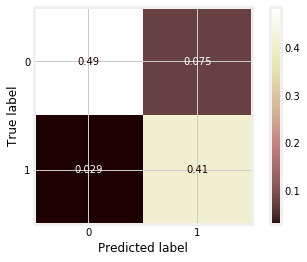

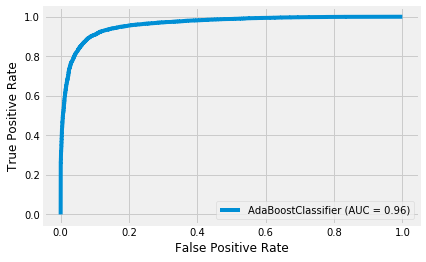

In [57]:
from sklearn.ensemble import AdaBoostClassifier as adab
params_adab ={'n_estimators': 500,
              'random_state': 12345}

model_adab = adab(**params_adab)
model_adab, accuracy_adab, roc_auc_adab, tt_adab = run_model(model_adab, X_train, y_train, X_test, y_test)

Decision Region Plotting for Different Models¶
We will observe the boundary of decision regions plotted by all the models on training data. Also we will observe the number of misclassified data points in the plots.

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
import matplotlib.gridspec as gridspec
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.70
width = 0.85

clf1 = LogisticRegression(random_state=12345)
clf2 = GaussianNB()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier(random_state=12345) 
clf5 = MLPClassifier(random_state=12345, verbose = 0)
clf6 = RandomForestClassifier(random_state=12345)
clf7 = xgb.XGBClassifier(random_state=12345)
clf8 = AdaBoostClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf6, clf7, clf8], weights=[1, 1, 1], voting='soft')

X_list = traindf[["Type_of_Travel", "Inflight_wifi_service", "Online_boarding", "Seat_comfort"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = traindf["satisfaction"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Naive Bayes',
          'KNN',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'XGBoost',
          'AdaBoost',
          'Ensemble']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value, 3: value}, 
                                filler_feature_ranges={2: width, 3: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

ModuleNotFoundError: No module named 'xgboost'

### Model Comparison:
We will compare the performace of various models by their respective ROC_AUC score and total time taken for execution.

In [60]:
roc_auc_scores = [roc_auc_lr, roc_auc_nb, roc_auc_kn, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb, roc_auc_adab]
tt = [tt_lr, tt_nb, tt_kn, tt_dt, tt_nn, tt_rf, tt_xgb, tt_adab]

model_data = {'Model': ['Logistic Regression','Naive Bayes','K-NN','Decision Tree','Neural Network','Random Forest','XGBoost','AdaBoost'],
              'ROC_AUC': roc_auc_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve and Time taken for execution by Various Models', fontsize=13)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='Blues_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='ROC_AUC', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

NameError: name 'roc_auc_xgb' is not defined

### Conclusion
We observe, Random Forest and AdaBoost have performed equally well on producing high ROC_AUC score (90%). But Random Forest has taken lesser amount of time compared to time taken by AdaBoost. So, we will stick to Random Forest as the best model.
#### Acknowledgement: 